In [1]:
## import libraries

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets , models , transforms
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from sklearn.metrics import classification_report , confusion_matrix
from PIL import Image
%matplotlib inline


In [2]:
## Path , join

path = r"C:\Users\MANISH SHARMA\Desktop\deeplearning-pytorch\malaria"
train = os.path.join(path , "Train")
test = os.path.join(path ,"Test")

In [3]:
## Transformation

trans = transforms.Compose([
    transforms.Resize(112) , transforms.CenterCrop(112)  , transforms.RandomHorizontalFlip(p= 0.4) ,
    transforms.RandomVerticalFlip(p=0.5)  ,transforms.ToTensor()
])

In [4]:
## Joining the datasets

train_data = datasets.ImageFolder(train , transform = trans)
test_data = datasets.ImageFolder(test , transform = trans)

print(len(train_data) , len(test_data))

416 134


In [5]:
## Split the train_data into train and val

def split(n , p , random):
    s = int(n*p)
    np.random.seed(random)
    idx = np.random.permutation(n)
    
    return idx[s:] , idx[:s]

train_idx , val_idx = split(len(train_data) , 0.2 , 100)

In [6]:
## print
print(len(train_idx) , len(val_idx))

333 83


In [7]:
## make loader
train_load = SubsetRandomSampler(train_idx)
val_load = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_data , batch_size = 4  , sampler=train_load )
val_loader = DataLoader(train_data , batch_size = 4 , sampler=val_load )
test_loader = DataLoader(test_data , batch_size = 1  , shuffle = True)


In [8]:
## check images size
print(train_data.classes)
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

img , lab = train_data[0]
print(img.shape)


['Non-Parasitic', 'Parasitic']
84
21
134
torch.Size([3, 112, 112])


Non-Parasitic 0


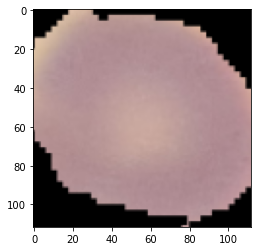

In [9]:
## plot image --- train_data
img , labels = train_data[0]
plt.imshow(img.permute(1,2,0))
print(train_data.classes[labels] , labels)
plt.show()

Non-Parasitic 0


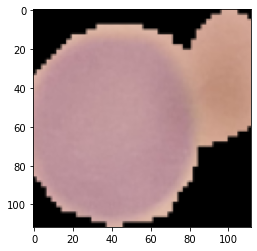

In [10]:
## plot image --- test data

img , labels = test_data[0]
plt.imshow(img.permute(1,2,0))
print(test_data.classes[labels] , labels)
plt.show()

torch.Size([4, 3, 112, 112])
Label is  tensor(0)


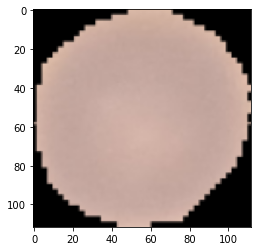

In [11]:
## plot image -- train_loader
for img , lab in train_loader:
    print(img.shape)
    plt.imshow(img[0].permute(1,2,0))
    print("Label is " , lab[0])
    break

torch.Size([4, 3, 112, 112])
Label is  tensor(1)


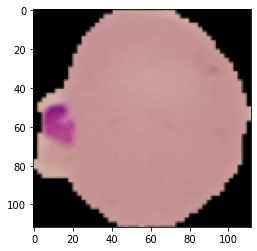

In [12]:
## plot image -- val_loader
for img , lab in val_loader:
    print(img.shape)
    plt.imshow(img[0].permute(1,2,0))
    print("Label is " , lab[0])
    break

torch.Size([1, 3, 112, 112])
Label is  tensor(1)


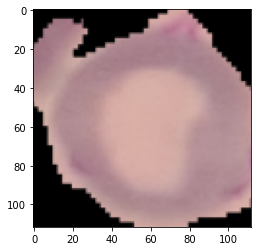

In [13]:
## plot image -- test_loader
for img , lab in test_loader:
    print(img.shape)
    plt.imshow(img[0].permute(1,2,0))
    print("Label is " , lab[0])
    break

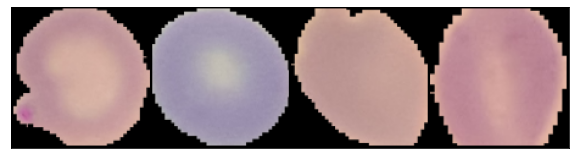

In [14]:
## Plot batch images (train_Loader)
def grid(dl):
    for img , lab in dl:
        fig , ax = plt.subplots(figsize = (10 ,10))
        ax.set_xticks([]) ; ax.set_yticks([])
        ax.imshow(make_grid(img , 8).permute(1,2,0))
        break
        
grid(train_loader)
        
    

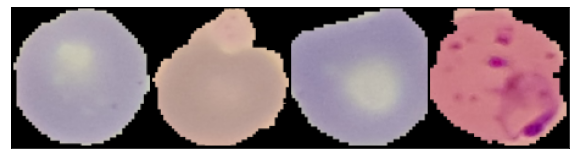

In [15]:
## val loader
grid(val_loader)

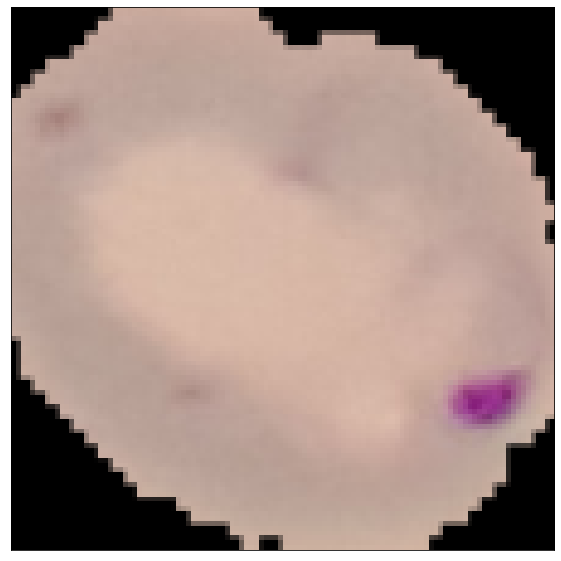

In [16]:
grid(test_loader)  #batch size =1

In [17]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if  train_on_gpu:
    print('CUDA is  available.  Training on GPU ...')
    device = "cuda"
else:
    print('CUDA is not available!  Training on CPU ...')
    device = "cpu"

CUDA is  available.  Training on GPU ...


In [18]:
## Use transfer learning (model = vgg16)
model = models.resnet152(pretrained = True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
## freeze params
for param in model.fc.parameters():
    param.required_grad = False

In [20]:
## change the output layer
num_ftrs = model.fc.in_features
out = 2     #( pred class)
model.fc = nn.Linear(num_ftrs, out)

model = model.to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
## optimizer and loss_func
optimizer = optim.Adam(model.fc.parameters() , lr = 0.001)
loss_func = nn.CrossEntropyLoss()

In [22]:
### training on train and test on val

## training 

epoch = 10
val_loss_min = np.Inf

for i in (range(epoch)):
    train_plot_acc , train_plot_loss , val_plot_acc , val_plot_loss = [],[],[],[]
    train_loss = 0
    val_loss = 0
    train_acc = 0
    val_acc = 0
    
    # train_loader
    for img , lab in tqdm(train_loader):
        img , lab = img.to("cuda") , lab.to("cuda")
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output , lab)
        
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == lab).float().mean()).item()
        train_acc += acc/ len(train_loader)
        train_loss += loss.item() / len(train_loader)
        
        train_plot_loss.append(train_loss)
        train_plot_acc.append(train_acc)
        
    # Val_loader    
    for img , lab in tqdm(val_loader):
        img , lab = img.to("cuda") , lab.to("cuda")
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output , lab)
        
        
        v_acc = ((output.argmax(dim=1) == lab).float().mean()).item()
        val_acc += v_acc/ len(val_loader)
        val_loss += loss.item() / len(val_loader)
        
        val_plot_loss.append(val_loss)
        val_plot_acc.append(val_acc)
        
    print("Epoch {} , Train_loss = {:.4f} , Val_loss = {:.4f} , Train_acc = {:.4f} , Val_acc = {:.4f}".format(
                    i+1 , train_loss , val_loss , train_acc , val_acc))
        
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(model.state_dict(), 'malaria_resnet152.pt')
        val_loss_min = val_loss

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.72it/s]


Epoch 1 , Train_loss = 0.6223 , Val_loss = 0.3206 , Train_acc = 0.7054 , Val_acc = 0.8571
Validation loss decreased (inf --> 0.3206).  Saving model ...


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 2 , Train_loss = 0.3403 , Val_loss = 0.3581 , Train_acc = 0.8452 , Val_acc = 0.8135


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 3 , Train_loss = 0.4335 , Val_loss = 0.3256 , Train_acc = 0.7946 , Val_acc = 0.8413


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.13it/s]


Epoch 4 , Train_loss = 0.3758 , Val_loss = 0.2614 , Train_acc = 0.8393 , Val_acc = 0.9048
Validation loss decreased (0.3206 --> 0.2614).  Saving model ...


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 5 , Train_loss = 0.4041 , Val_loss = 0.3798 , Train_acc = 0.8452 , Val_acc = 0.8571


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 6 , Train_loss = 0.4769 , Val_loss = 0.3563 , Train_acc = 0.8125 , Val_acc = 0.8571


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 7 , Train_loss = 0.4097 , Val_loss = 0.2737 , Train_acc = 0.8393 , Val_acc = 0.8770


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 8 , Train_loss = 0.4841 , Val_loss = 0.2926 , Train_acc = 0.8423 , Val_acc = 0.9048


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

Epoch 9 , Train_loss = 0.4321 , Val_loss = 0.3194 , Train_acc = 0.8393 , Val_acc = 0.9008


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.27it/s]


Epoch 10 , Train_loss = 0.4344 , Val_loss = 0.2287 , Train_acc = 0.8155 , Val_acc = 0.9167
Validation loss decreased (0.2614 --> 0.2287).  Saving model ...


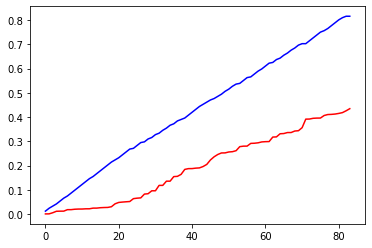

In [23]:
plt.plot(train_plot_acc  , color = "blue")
plt.plot(train_plot_loss , color = "red")

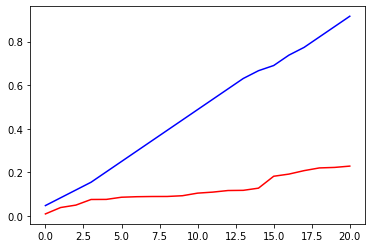

In [24]:
plt.plot(val_plot_loss , color = "red")
plt.plot(val_plot_acc , color = "blue")

In [25]:
#testing
#test with test_loader


model.load_state_dict(torch.load("malaria_resnet152.pt"))
model.cuda()
model.eval()

with torch.no_grad():
    test_accuracy=0
    test_loss =0
    op_l = []
    lab = []
    for data, label in test_loader:
        data = data.to("cuda")
        label = label.to("cuda")

        output = model(data)
        loss = loss_func(output,label)


        acc = ((output.argmax(dim=1) == label).float().mean()).item()
        op_l.append((output.argmax(dim =1)).item())
        lab.append(label.item())
        test_accuracy += acc/ len(test_loader)
        
        test_loss += loss/ len(test_loader)
        

    print('test_accuracy : {}, test_loss : {}'.format(test_accuracy,test_loss))


test_accuracy : 0.888059701492539, test_loss : 3.1405258178710938


In [26]:
print("predicted output"  ,op_l[:10])

predicted output [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [27]:
print("Original label" , lab[:10])

Original label [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [28]:
#metrics

print(confusion_matrix(op_l , lab))
print(classification_report(op_l , lab))

[[43 15]
 [ 0 76]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        58
           1       0.84      1.00      0.91        76

    accuracy                           0.89       134
   macro avg       0.92      0.87      0.88       134
weighted avg       0.91      0.89      0.88       134



torch.Size([1, 3, 112, 112])


'Parasitic'

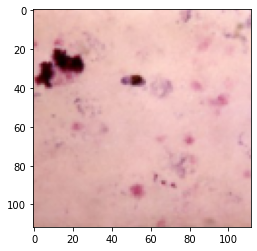

In [29]:
## test with your own image

model.eval()
img_name = r"C:\Users\MANISH SHARMA\Desktop\deeplearning-pytorch\malaria\infect.jpg" # change this to the name of your image file.
def predict_image(image_path, model):
    image = Image.open(image_path)
    image_tensor = trans(image)
    image_tensor = image_tensor.unsqueeze(0)
    plt.imshow(image_tensor[0].permute(1,2,0))
    image_tensor = image_tensor.to(device)
    print(image_tensor.shape)
    
    output = model(image_tensor)
    index = output.argmax().item()
    if index == 0:
        return "Non-Parasitic"
    elif index == 1:
        return "Parasitic"
    else:
        return


predict_image(img_name,model)

torch.Size([1, 3, 112, 112])


'Non-Parasitic'

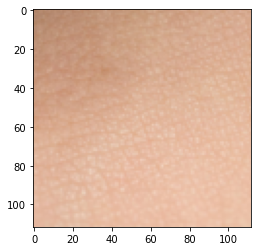

In [30]:
## test with your own image

model.eval()
img_name = r"C:\Users\MANISH SHARMA\Desktop\deeplearning-pytorch\malaria\not-infect.jpg" # change this to the name of your image file.
def predict_image(image_path, model):
    image = Image.open(image_path)
    image_tensor = trans(image)
    image_tensor = image_tensor.unsqueeze(0)
    plt.imshow(image_tensor[0].permute(1,2,0))
    image_tensor = image_tensor.to(device)
    print(image_tensor.shape)
    
    output = model(image_tensor)
    index = output.argmax().item()
    if index == 0:
        return "Non-Parasitic"
    elif index == 1:
        return "Parasitic"
    else:
        return


predict_image(img_name,model)